In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),
                         (0.5,0.5,0.5))
])


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [4]:
trainset = torchvision.datasets.CIFAR10(
    root='../data',
    train=True,
    download=False,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='../data',
    train=False,
    download=False,
    transform=transform
)


In [5]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=32,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=32,
    shuffle=False
)


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self).__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8,128)
        self.fc2 = nn.Linear(128,10)
    
    def forward(self,x):
        x= self.pool(F.relu(self.conv1(x)))
        x= self.pool(F.relu(self.conv2(x)))
        x=x.view(x.size(0),-1)
        x= F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

In [7]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [8]:
num_epochs = 15

train_loss_history = []
train_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_acc_history.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.2f}% "
          f"Test Acc: {test_acc:.2f}%")


Epoch [1/15] Loss: 1.2992 Train Acc: 53.36% Test Acc: 61.47%
Epoch [2/15] Loss: 0.9296 Train Acc: 67.10% Test Acc: 68.71%
Epoch [3/15] Loss: 0.7707 Train Acc: 73.04% Test Acc: 70.77%
Epoch [4/15] Loss: 0.6475 Train Acc: 77.26% Test Acc: 70.97%
Epoch [5/15] Loss: 0.5393 Train Acc: 80.99% Test Acc: 70.53%
Epoch [6/15] Loss: 0.4444 Train Acc: 84.21% Test Acc: 72.27%
Epoch [7/15] Loss: 0.3615 Train Acc: 87.11% Test Acc: 70.01%
Epoch [8/15] Loss: 0.2892 Train Acc: 89.71% Test Acc: 70.79%
Epoch [9/15] Loss: 0.2277 Train Acc: 91.94% Test Acc: 70.67%
Epoch [10/15] Loss: 0.1785 Train Acc: 93.61% Test Acc: 70.67%
Epoch [11/15] Loss: 0.1467 Train Acc: 94.76% Test Acc: 70.10%
Epoch [12/15] Loss: 0.1326 Train Acc: 95.36% Test Acc: 70.36%
Epoch [13/15] Loss: 0.1179 Train Acc: 95.89% Test Acc: 69.28%
Epoch [14/15] Loss: 0.0966 Train Acc: 96.66% Test Acc: 69.77%
Epoch [15/15] Loss: 0.0896 Train Acc: 96.87% Test Acc: 70.02%


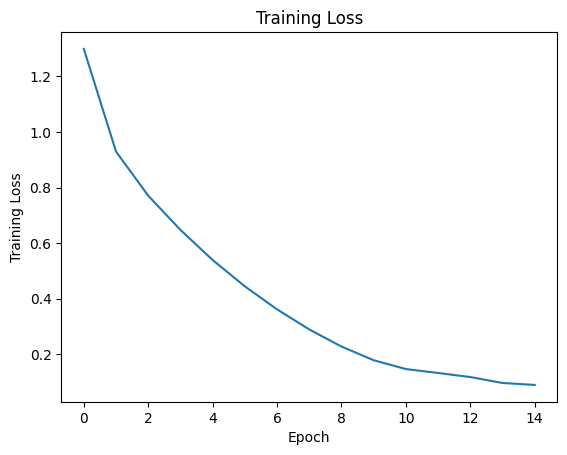

In [9]:
plt.figure()
plt.plot(train_loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss")
plt.show()

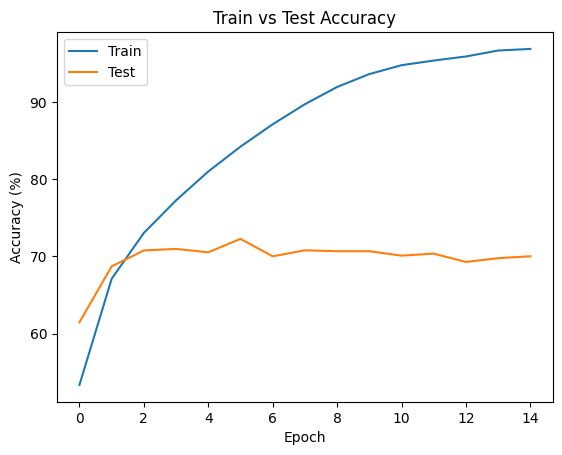

In [10]:
plt.figure()
plt.plot(train_acc_history)
plt.plot(test_acc_history)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend(["Train", "Test"])
plt.show()

### Why MLP Struggles With Images

In MLP we flatten the image:

```python
x = x.view(x.size(0), -1)
```

Example:

$$
28 \times 28 \rightarrow 784
$$

The 2D image becomes a 1D vector.

Problem:

Pixels that were neighbors in 2D become unrelated values in a long vector.

So spatial structure is destroyed.

Image understanding requires:

- Edges
- Shapes
- Local patterns

MLP cannot efficiently capture spatial locality.

### Enter Convolutional Neural Networks (CNN)

CNN keeps the 2D structure of images.

Instead of flattening early, CNN applies convolution filters to local regions.

### What Is Convolution (Intuition)

Example vertical edge detector:

$$
\begin{bmatrix}
1 & 0 & -1 \\
1 & 0 & -1 \\
1 & 0 & -1
\end{bmatrix}
$$

This filter slides across the image.

At each position it computes:

$$
Output = \sum (Image \odot Filter)
$$

Where:

- $\odot$ means element-wise multiplication
- Then all values are summed

This produces a feature map.

### Convolution Mathematical Form

Let:

- Input image = $I$
- Kernel (filter) = $K$

Then output at position $(i,j)$:

$$
O(i,j) = \sum_m \sum_n I(i+m, j+n) \cdot K(m,n)
$$

This is a weighted local sum.

### Why Convolution Is Powerful

1. Local Connectivity  
Each neuron sees only a small region (like 3×3 or 5×5).

2. Weight Sharing  
The same filter is applied across the entire image.

3. Translation Invariance  
The network can detect the same feature anywhere in the image.

### Parameter Comparison

MLP first layer example:

$$
784 \times 128 = 100,352
$$

CNN first layer example:

$$
3 \times 3 \times 1 \times 16 = 144
$$

CNN uses far fewer parameters.

### CNN Basic Architecture

Typical CNN pipeline:

Input Image  
↓  
Convolution  
↓  
ReLU  
↓  
Pooling  
↓  
Convolution  
↓  
ReLU  
↓  
Pooling  
↓  
Flatten  
↓  
Fully Connected  
↓  
Output  

### What Is Pooling

Pooling reduces spatial dimensions.

Example 2×2 Max Pool:

$$
\begin{bmatrix}
1 & 5 \\
3 & 2
\end{bmatrix}
\rightarrow 5
$$

Max pooling keeps the strongest activation.

Benefits:

- Reduces computation
- Adds robustness to small shifts
- Helps prevent overfitting

### Why CNN Outperforms MLP for Images

CNN:

- Preserves spatial structure
- Learns local features
- Uses fewer parameters
- Generalizes better on images

MLP:

- Ignores spatial layout
- Has many parameters
- Struggles with image complexity